In [5]:
import requests
import pandas as pd
from datetime import datetime
import time

# Configure the API
TOKEN = "YOUR TOKEN HERE"
STATION_ID = "GHCND:USW00094846"  # Chicago O'Hare
DATASET_ID = "GHCND"
UNITS = "standard"

HEADERS = {"token": TOKEN}
BASE_URL = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

# Fetch the data
def get_noaa_data(year):
    """Fetch daily data for a given year with pagination"""
    all_records = []
    offset = 1
    limit = 1000

    params = {
        "datasetid": DATASET_ID,
        "stationid": STATION_ID,
        "startdate": f"{year}-01-01",
        "enddate": f"{year}-12-31",
        "units": UNITS,
        "limit": limit,
        "offset": offset,
    }

    while True:
        response = requests.get(BASE_URL, headers=HEADERS, params=params)
        if response.status_code != 200:
            print(f"Error {response.status_code}: {response.text}")
            break

        data = response.json()
        results = data.get("results", [])
        if not results:
            break

        all_records.extend(results)

        # Pagination
        if len(results) < limit:
            break
        params["offset"] += limit

        time.sleep(0.3)

    return all_records


# How much data to fetch
all_data = []
for year in [2023, 2024, 2025]:
    print(f"Fetching {year}...")
    records = get_noaa_data(year)
    print(f"  → {len(records)} records fetched for {year}")
    all_data.extend(records)

print(f"✅ Total records fetched: {len(all_data)}")

# Convert to Dataframes
if all_data:
    df = pd.DataFrame(all_data)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df_pivot = df.pivot_table(
        index="date", columns="datatype", values="value", aggfunc="mean"
    ).reset_index()

    print("✅ NOAA data shape:", df_pivot.shape)
    print(df_pivot.head())
else:
    print("⚠️ No data fetched — check your NOAA token or date range.")




Fetching 2023...
Error 400: {"status" : "400", "message" : "The token parameter provided is not valid."}
  → 0 records fetched for 2023
Fetching 2024...
Error 400: {"status" : "400", "message" : "The token parameter provided is not valid."}
  → 0 records fetched for 2024
Fetching 2025...
Error 400: {"status" : "400", "message" : "The token parameter provided is not valid."}
  → 0 records fetched for 2025
✅ Total records fetched: 0
⚠️ No data fetched — check your NOAA token or date range.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Without fetching the API

In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Chicago-Jan-01-2023_to_Aug-31-2025.csv")
print("Initial shape:", df.shape)

# Check columns and missing values
print("\nColumns:\n", df.columns.tolist())
print("\nMissing values (top 10):\n", df.isna().sum().sort_values(ascending=False).head(10))

# Standardize datetime
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    df = df.dropna(subset=["datetime"])
else:
    raise ValueError("No 'datetime' column found — please check file structure")

# Drop irrelevant columns (as you decided)
drop_cols = ["stations", "description", "icon", "name"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Fill missing numeric values with interpolation
num_cols = df.select_dtypes(include=[np.number]).columns

for col in num_cols:
    # Avoid interpolation errors on constant columns
    if df[col].nunique() > 1:
        df[col] = df[col].interpolate(method="linear", limit_direction="both")
    else:
        df[col] = df[col].fillna(df[col].iloc[0])

# Fill categorical text columns with mode
cat_cols = df.select_dtypes(exclude=[np.number]).columns
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0] if not df[c].mode().empty else "Unknown")

# Add datetime features
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df["dayofweek"] = df["datetime"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6])

print("\n✅ Cleaned Data Summary:")
print(df.info())
print("\nPreview:")
print(df.head())

df.to_csv("/content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv", index=False)
print("\n💾 Cleaned dataset saved to /content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv")


Initial shape: (974, 33)

Columns:
 ['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations']

Missing values (top 10):
 preciptype      577
severerisk      102
name              0
tempmin           0
datetime          0
feelslikemax      0
feelslikemin      0
feelslike         0
tempmax           0
dew               0
dtype: int64

✅ Cleaned Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          974 non-null    datetime64[ns]
 1   tempmax      

EDA

In [18]:
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv", parse_dates=["datetime"], infer_datetime_format=True)
print("shape:", weather.shape)
print(weather.dtypes)
print(weather.head())
# Missingness
miss = weather.isna().sum().sort_values(ascending=False)
print(miss[miss>0])
# Basic ranges
print(weather[['tempmax','tempmin','precip','windspeed']].describe())


shape: (974, 33)
datetime            datetime64[ns]
tempmax                    float64
tempmin                    float64
temp                       float64
feelslikemax               float64
feelslikemin               float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipprob                   int64
precipcover                float64
preciptype                  object
snow                       float64
snowdepth                  float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                      int64
severerisk                 float64
sunrise                     object
sunset                      object
moonphase                  float64
con

/tmp/ipython-input-1086403368.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv", parse_dates=["datetime"], infer_datetime_format=True)


/tmp/ipython-input-3136144738.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weather.set_index('datetime')['tempmax'].isna().resample('M').mean().plot(title='Monthly % missing tempmax')


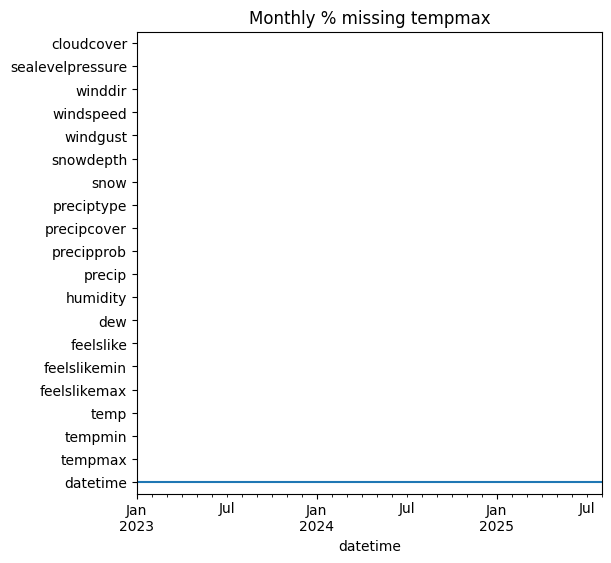

In [19]:
import matplotlib.pyplot as plt
# percent missing
pct = weather.isna().mean().sort_values(ascending=False)*100
pct.head(20).plot.barh(figsize=(6,6)); plt.title("Percent missing by column"); plt.xlabel("% missing")
# time-based missingness (per month)
weather.set_index('datetime')['tempmax'].isna().resample('M').mean().plot(title='Monthly % missing tempmax')
plt.show()

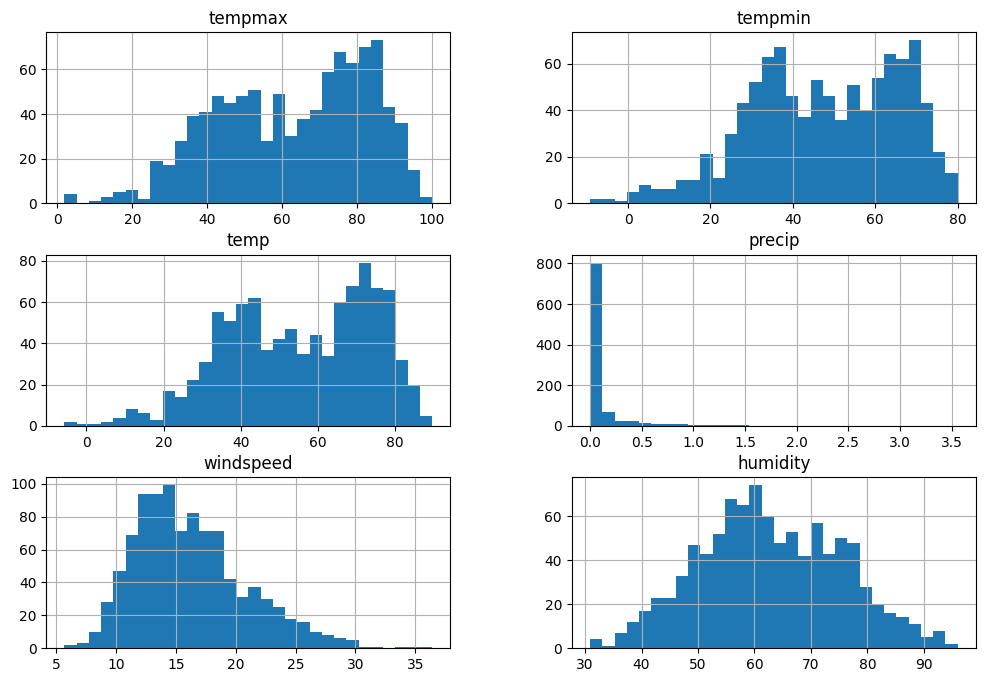

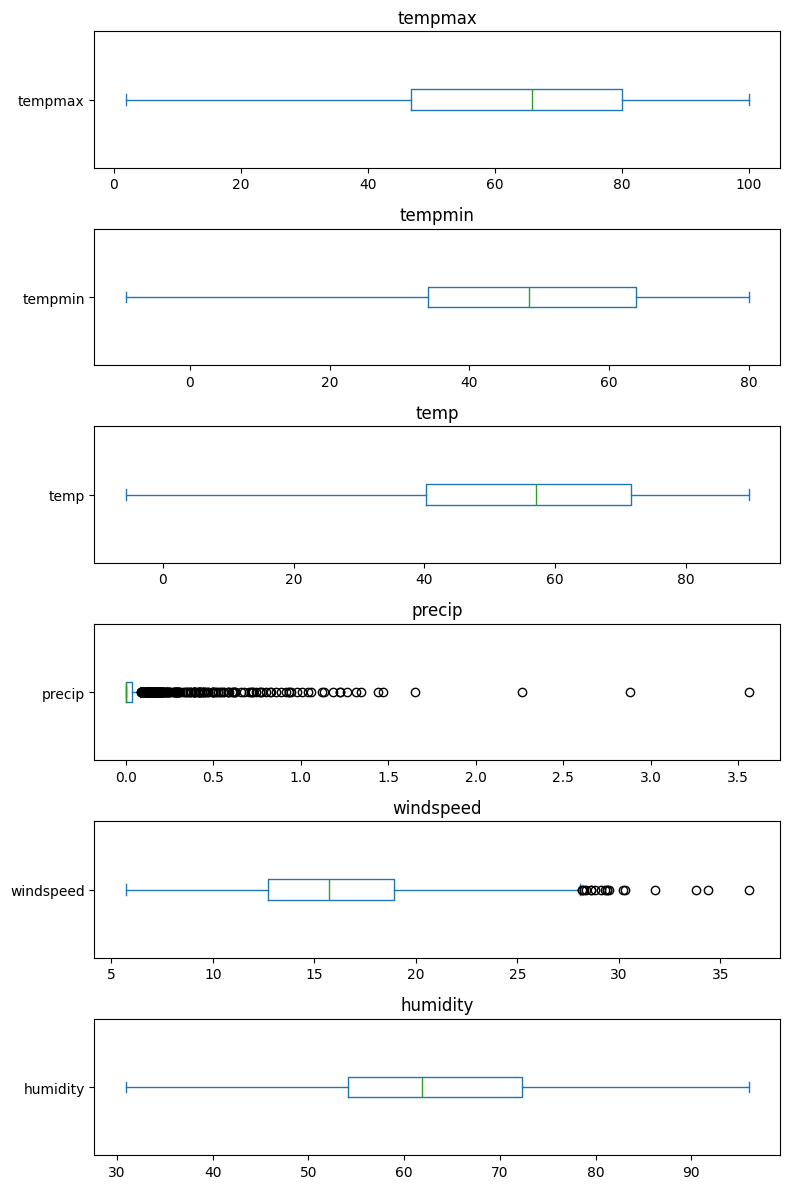

In [20]:
cols = ['tempmax','tempmin','temp','precip','windspeed','humidity']
weather[cols].hist(bins=30, figsize=(12,8))
plt.show()

# Boxplots to identify extreme outliers
fig, ax = plt.subplots(len(cols),1, figsize=(8,12))
for i,c in enumerate(cols):
    weather[c].plot.box(ax=ax[i], vert=False); ax[i].set_title(c)
plt.tight_layout(); plt.show()

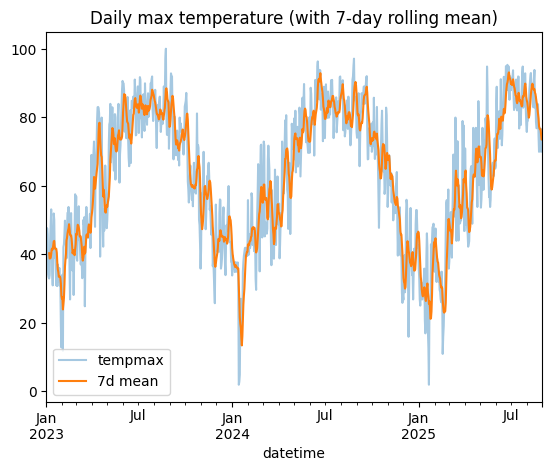

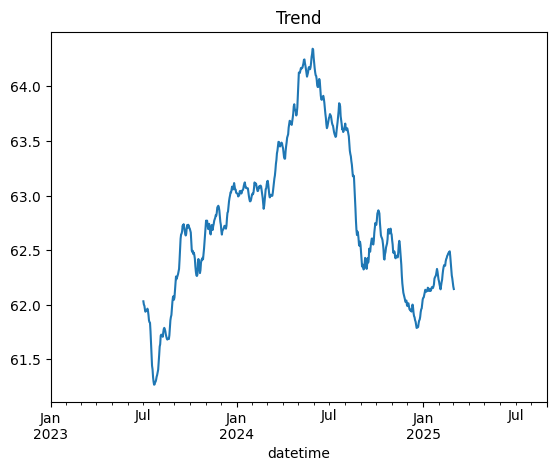

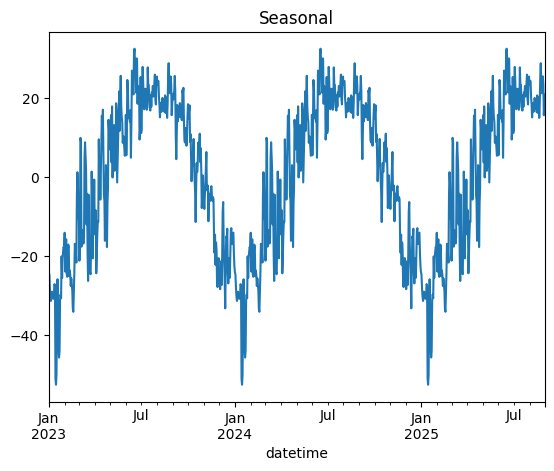

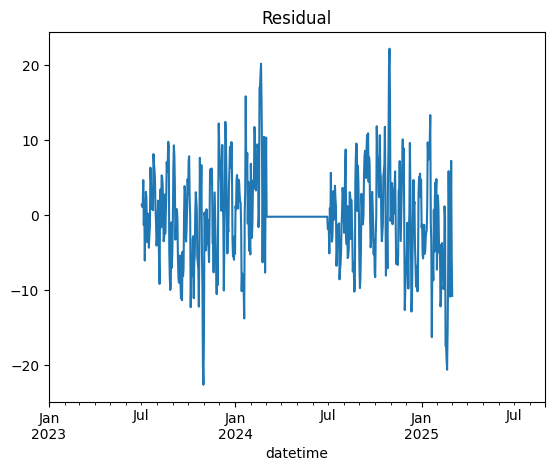

In [21]:
# daily plot + 7-day rolling mean
weather = weather.sort_values('datetime').set_index('datetime')
weather['tempmax'].plot(alpha=0.4, label='tempmax'); weather['tempmax'].rolling(7).mean().plot(label='7d mean')
plt.legend(); plt.title('Daily max temperature (with 7-day rolling mean)')
plt.show()

# Seasonal decomposition (requires statsmodels)
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(weather['tempmax'].dropna(), model='additive', period=365)
res.trend.plot(title='Trend'); plt.show()
res.seasonal.plot(title='Seasonal'); plt.show()
res.resid.plot(title='Residual'); plt.show()

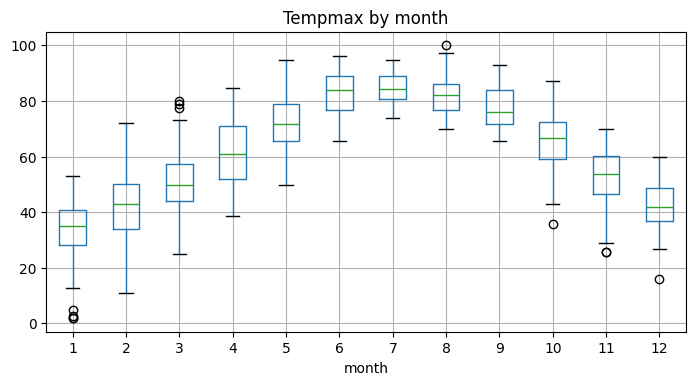

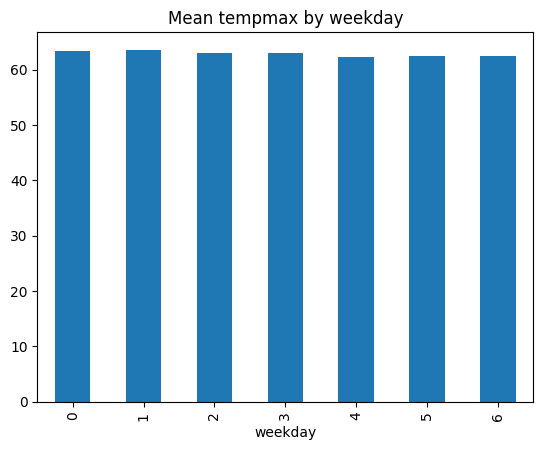

In [22]:
weather['month'] = weather.index.month
weather['weekday'] = weather.index.dayofweek
# boxplot by month
weather.boxplot(column='tempmax', by='month', figsize=(8,4))
plt.title('Tempmax by month'); plt.suptitle(''); plt.show()

# weekday-hour pattern for hourly data (if you have hourly)
# example for daily: mean temp by weekday
weather.groupby('weekday')['tempmax'].mean().plot(kind='bar')
plt.title('Mean tempmax by weekday'); plt.show()

EDA for Additional Numeric Weather Columns


🟦 Additional Numeric Columns Summary:
              dew  visibility  cloudcover  solarradiation  solarenergy  \
count  974.000000  974.000000  974.000000      974.000000   974.000000   
mean    41.614887    9.282546   66.531314      150.146099    12.963450   
std     17.860414    1.293467   26.188608       89.468705     7.732007   
min    -16.600000    1.100000    0.000000        5.100000     0.400000   
25%     28.800000    9.300000   46.700000       76.000000     6.525000   
50%     41.600000    9.900000   70.200000      139.250000    12.000000   
75%     56.575000    9.900000   89.775000      225.700000    19.575000   
max     76.800000    9.900000  100.000000      365.400000    31.500000   

         windgust  sealevelpressure        snow   snowdepth  precipprob  \
count  974.000000        974.000000  974.000000  974.000000  974.000000   
mean    27.017762       1015.959035    0.052156    0.108316   38.911704   
std      8.189371          7.123875    0.353707    0.414836   48.7800

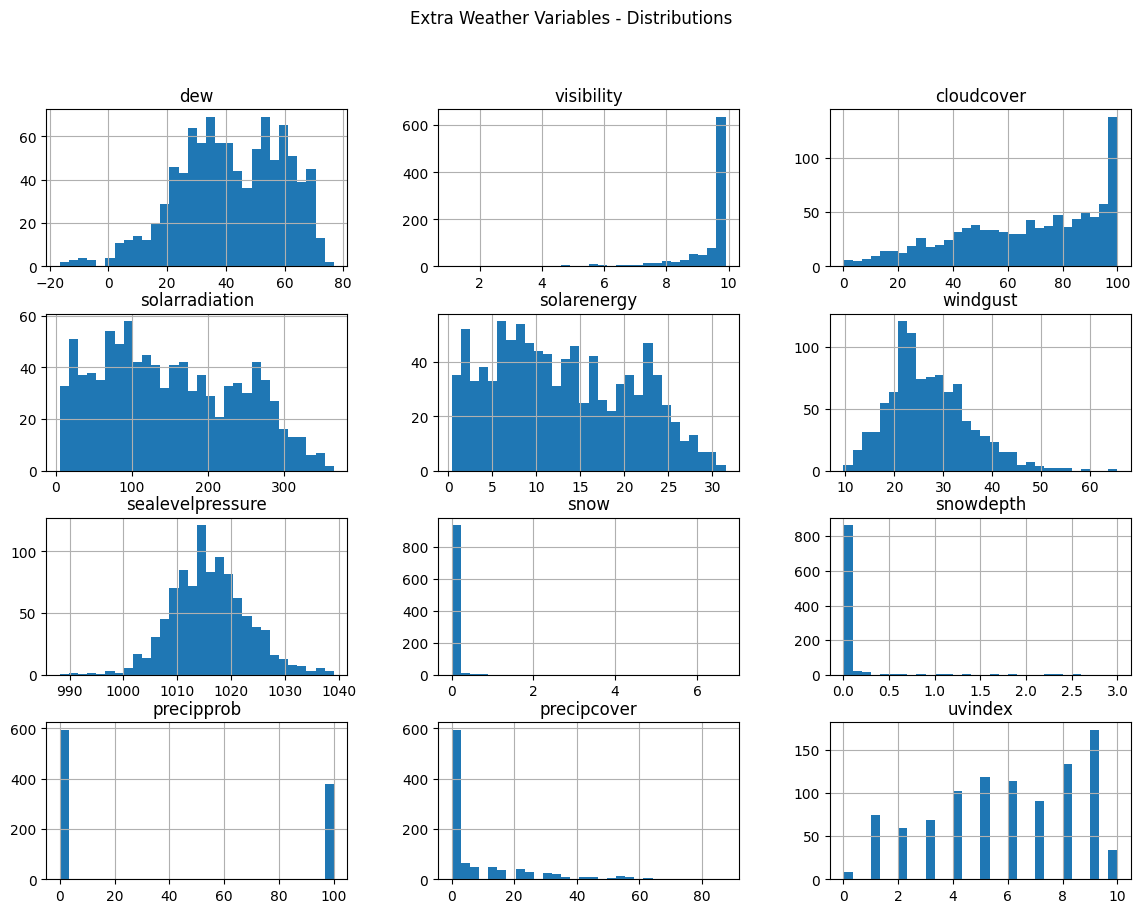

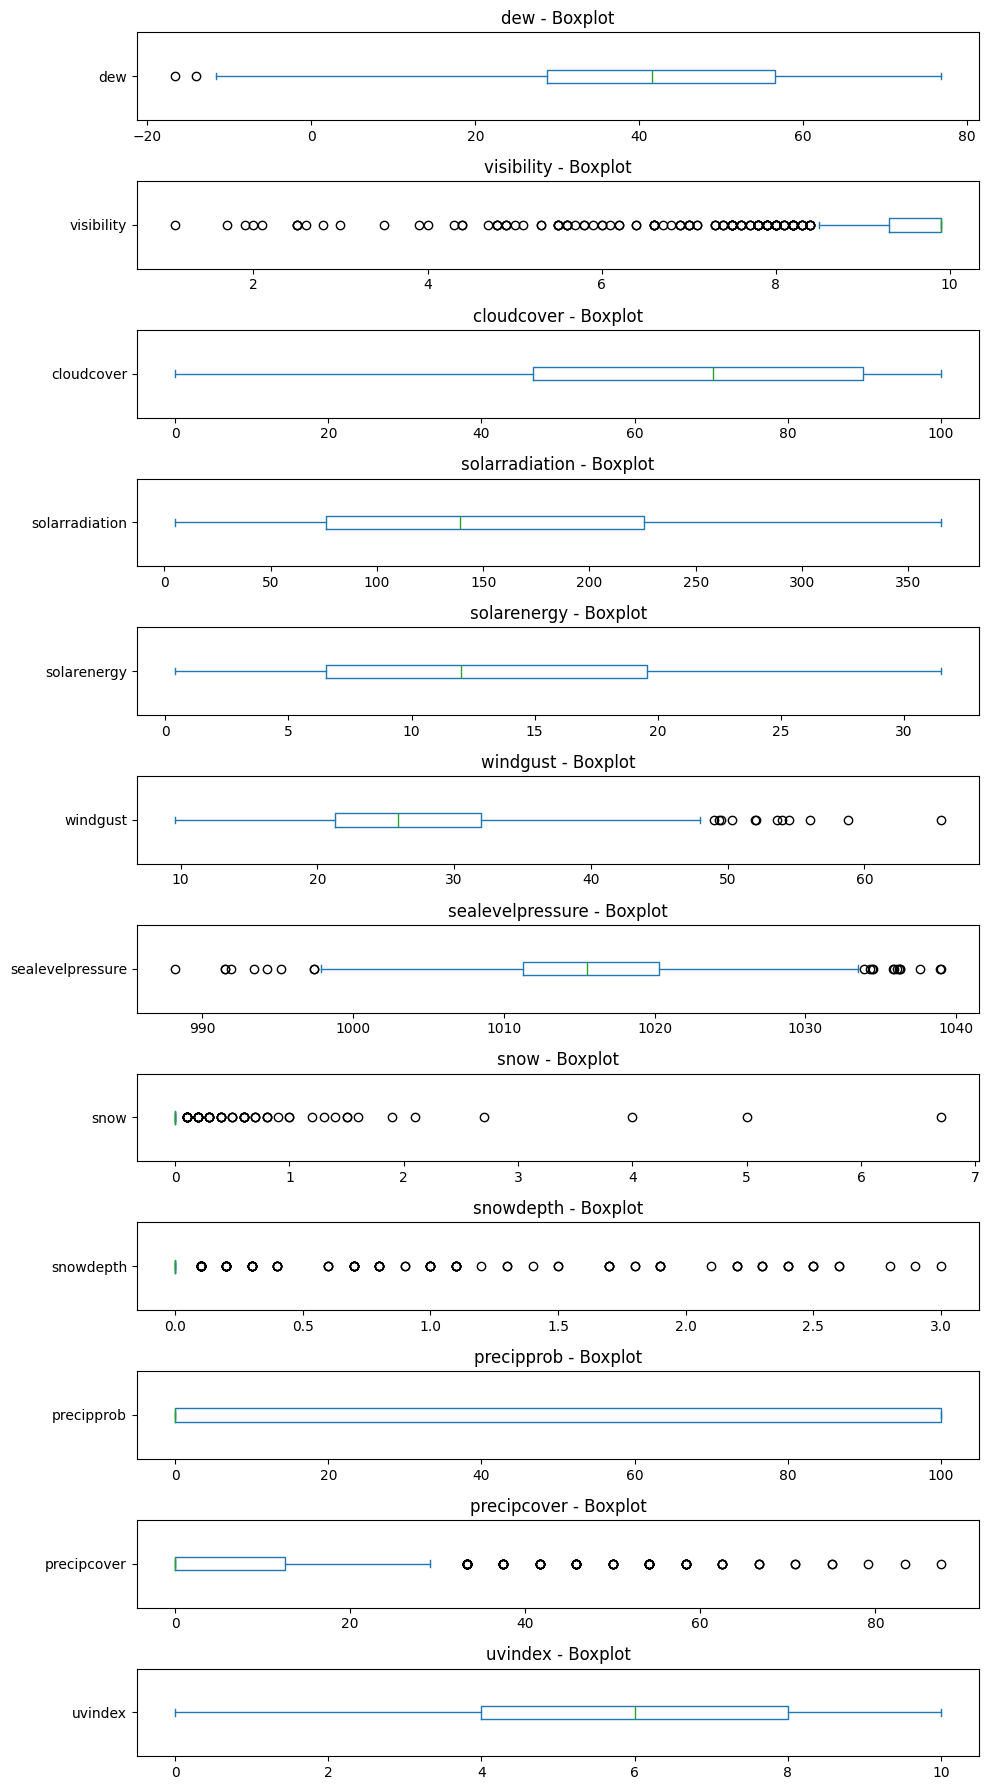

In [23]:
extra_numeric_cols = [
    'dew', 'visibility', 'cloudcover', 'solarradiation', 'solarenergy',
    'windgust', 'sealevelpressure', 'snow', 'snowdepth',
    'precipprob', 'precipcover', 'uvindex'
]

extra_numeric_cols = [c for c in extra_numeric_cols if c in weather.columns]

# Summary statistics
print("\n🟦 Additional Numeric Columns Summary:")
print(weather[extra_numeric_cols].describe())

# Histograms
weather[extra_numeric_cols].hist(bins=30, figsize=(14,10))
plt.suptitle("Extra Weather Variables - Distributions")
plt.show()

# Boxplots
fig, ax = plt.subplots(len(extra_numeric_cols), 1, figsize=(10,18))
for i,c in enumerate(extra_numeric_cols):
    weather[c].plot.box(ax=ax[i], vert=False)
    ax[i].set_title(f"{c} - Boxplot")
plt.tight_layout()
plt.show()


EDA for Precipitation Type (Categorical)


🟦 Precipitation Type Value Counts:
preciptype
rain         892
rain,snow     63
snow          19
Name: count, dtype: int64


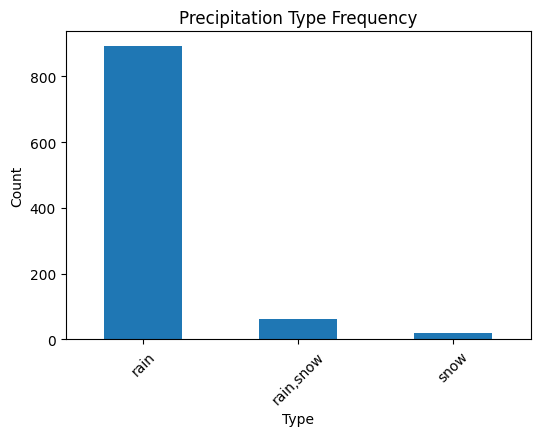

In [24]:
if 'preciptype' in weather.columns:
    print("\n🟦 Precipitation Type Value Counts:")
    print(weather['preciptype'].value_counts())

    weather['preciptype'].value_counts().plot(kind='bar', figsize=(6,4))
    plt.title("Precipitation Type Frequency")
    plt.xlabel("Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Daily Weather Condition Patterns (Categorical → Trend)

<Figure size 1200x600 with 0 Axes>

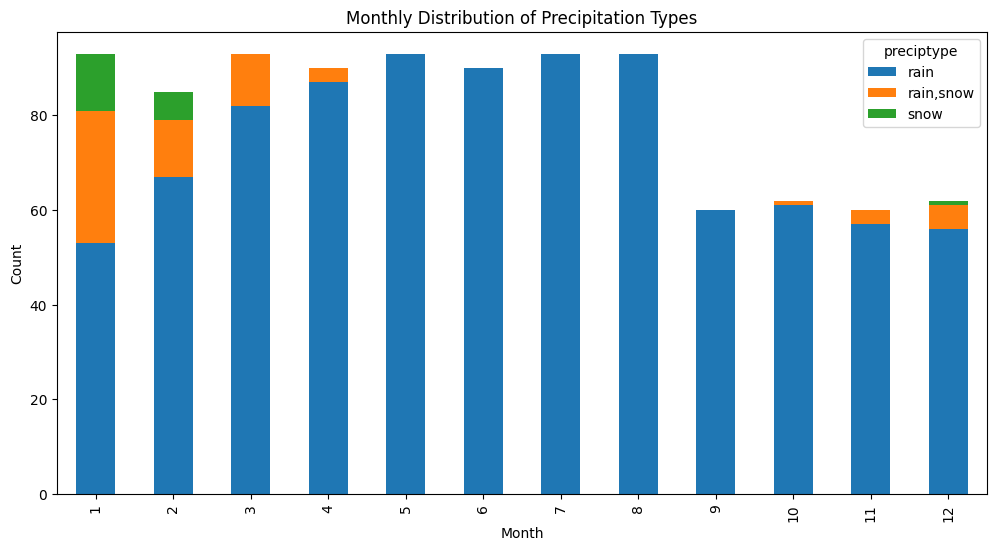

In [26]:
weather['month'] = weather.index.month

plt.figure(figsize=(12,6))
weather.groupby(['month', 'preciptype']).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Monthly Distribution of Precipitation Types")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()


Weather Extremes — Contribution Highlight


🟦 Extreme Weather Counts:
                                Count
Hot Days (tempmax > 90F)           54
Cold Days (tempmin < 20F)          68
Windy Days (windgust > 40 mph)     65
Heavy Rain (precip > 1 inch)       17
Low Visibility (< 2 miles)          3


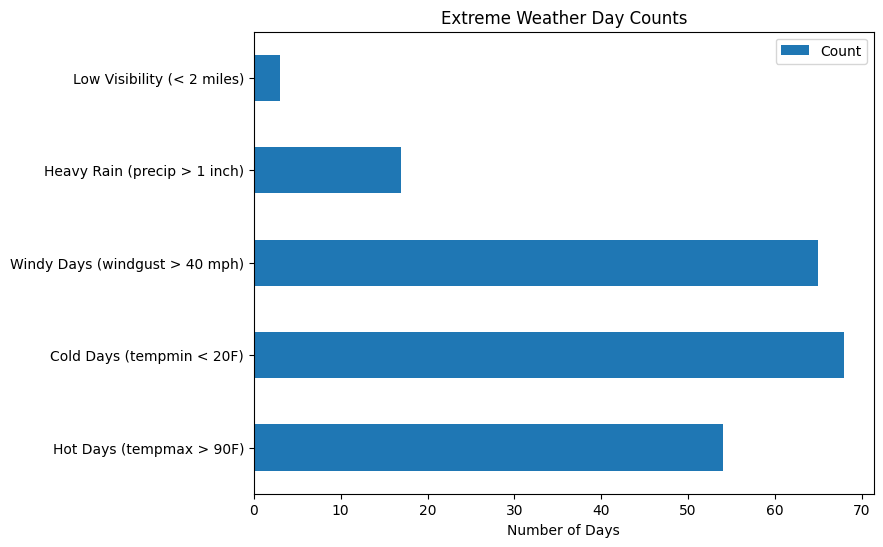

In [27]:
# Extreme days
extreme_weather = pd.DataFrame({
    'Hot Days (tempmax > 90F)': (weather['tempmax'] > 90).sum(),
    'Cold Days (tempmin < 20F)': (weather['tempmin'] < 20).sum(),
    'Windy Days (windgust > 40 mph)': (weather['windgust'] > 40).sum(),
    'Heavy Rain (precip > 1 inch)': (weather['precip'] > 1).sum(),
    'Low Visibility (< 2 miles)': (weather['visibility'] < 2).sum()
}, index=["Count"]).T

print("\n🟦 Extreme Weather Counts:")
print(extreme_weather)

extreme_weather.plot(kind='barh', figsize=(8,6))
plt.title("Extreme Weather Day Counts")
plt.xlabel("Number of Days")
plt.show()


Correlation Heatmap with ALL Weather Variables

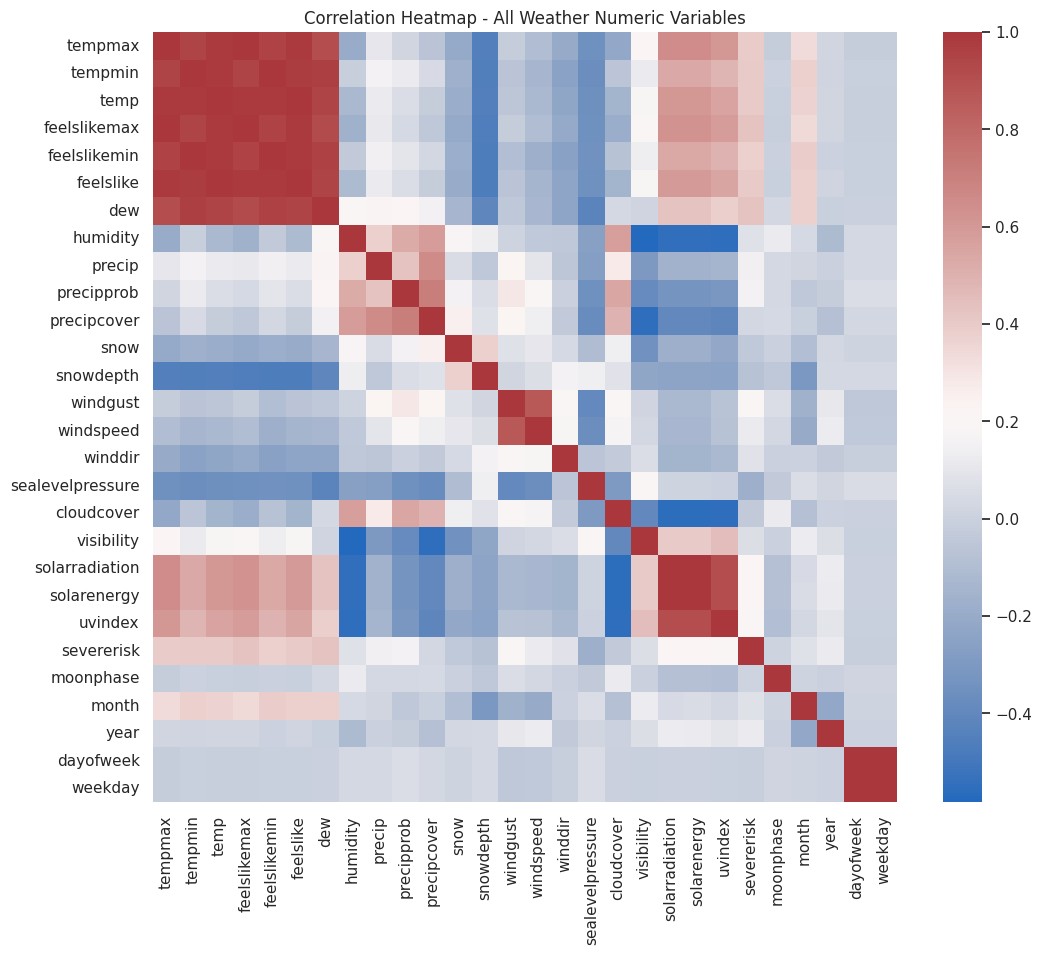

In [38]:
import seaborn as sns
plt.figure(figsize=(12,10))
sns.heatmap(weather.select_dtypes(include='number').corr(), cmap="vlag", annot=False)
sns.set_theme(style="darkgrid")
plt.title("Correlation Heatmap - All Weather Numeric Variables")
plt.show()

Time-Series Trends for New Columns

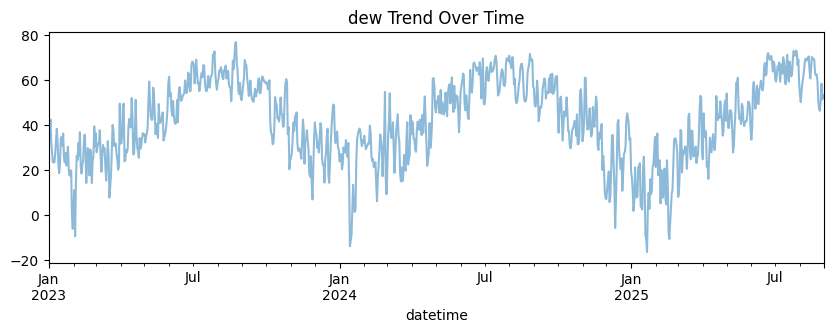

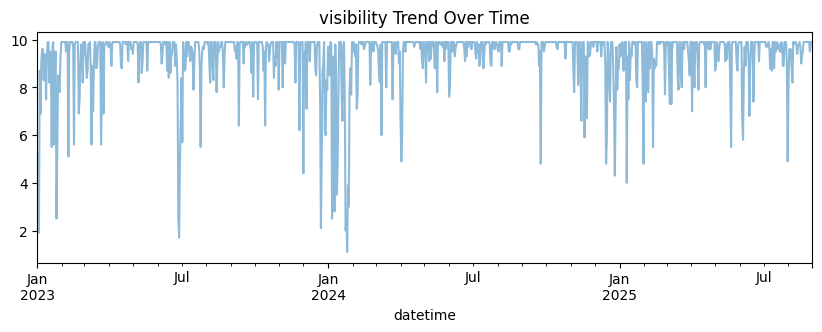

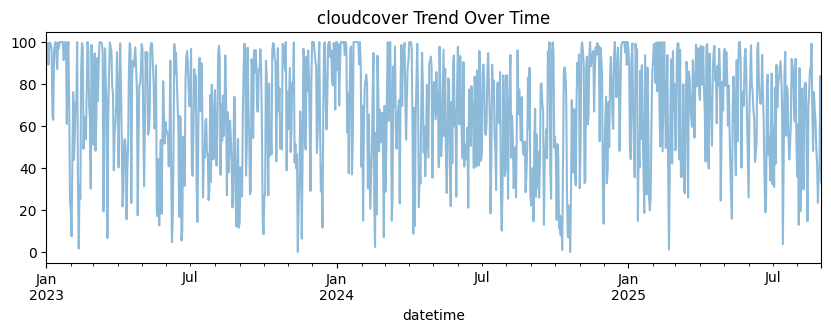

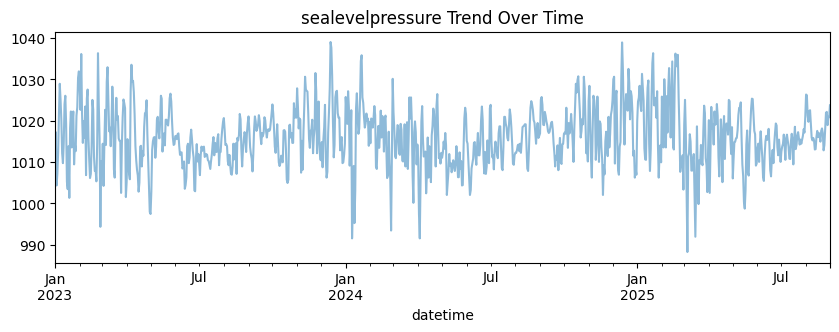

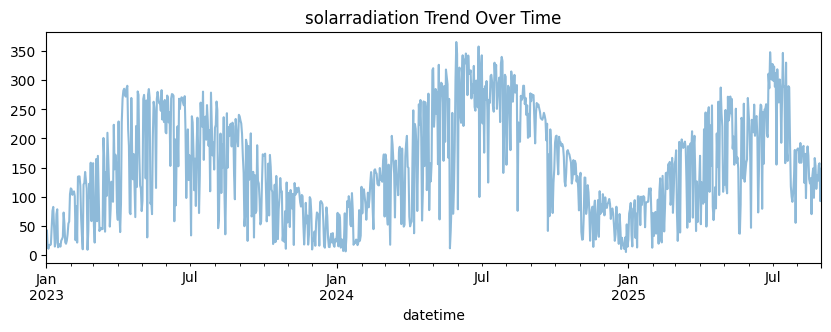

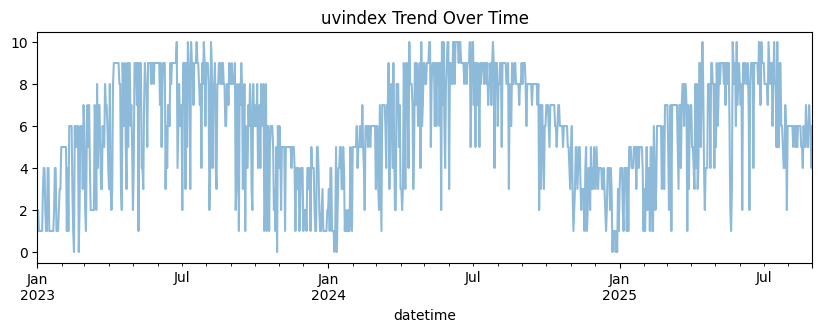

In [30]:
trend_cols = ['dew', 'visibility', 'cloudcover', 'sealevelpressure', 'solarradiation', 'uvindex']
trend_cols = [c for c in trend_cols if c in weather.columns]

for col in trend_cols:
    weather[col].plot(figsize=(10,3), alpha=0.5)
    plt.title(f"{col} Trend Over Time")
    plt.show()